In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [3]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [5]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [6]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


In [7]:
vae = Model(x, x_decoded_mean)

In [8]:
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
___________________________________________________________________________________________

In [10]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 6s - loss: 189.2178 - val_loss: 171.8162
Epoch 2/50
 - 4s - loss: 169.2868 - val_loss: 167.5402
Epoch 3/50
 - 4s - loss: 165.8363 - val_loss: 165.3050
Epoch 4/50
 - 4s - loss: 163.5785 - val_loss: 162.9999
Epoch 5/50
 - 4s - loss: 161.7495 - val_loss: 161.1732
Epoch 6/50
 - 4s - loss: 160.2649 - val_loss: 160.2280
Epoch 7/50
 - 4s - loss: 159.1012 - val_loss: 159.0545
Epoch 8/50
 - 4s - loss: 158.2262 - val_loss: 158.1520
Epoch 9/50
 - 5s - loss: 157.4805 - val_loss: 157.6044
Epoch 10/50
 - 5s - loss: 156.8769 - val_loss: 157.0199
Epoch 11/50
 - 5s - loss: 156.3560 - val_loss: 156.4839
Epoch 12/50
 - 5s - loss: 155.9146 - val_loss: 156.1225
Epoch 13/50
 - 4s - loss: 155.5268 - val_loss: 155.8885
Epoch 14/50
 - 5s - loss: 155.1420 - val_loss: 155.8296
Epoch 15/50
 - 5s - loss: 154.8037 - val_loss: 155.3642
Epoch 16/50
 - 5s - loss: 154.5240 - val_loss: 155.3204
Epoch 17/50
 - 4s - loss: 154.2479 - val_loss: 155.5334
Epoch 1

In [11]:
encoder = Model(x, z_mean)

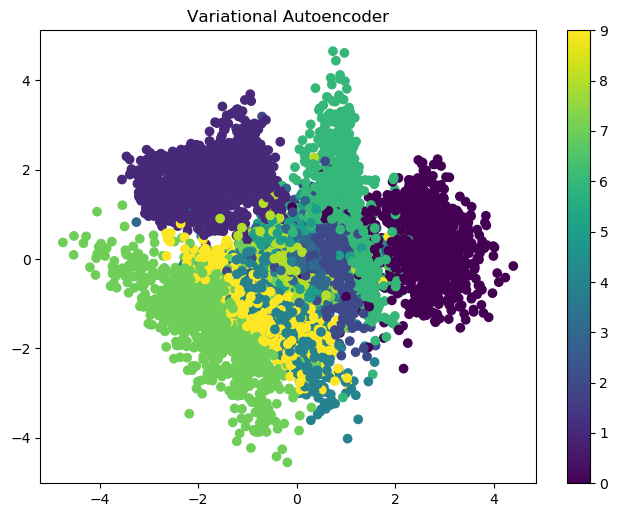

In [12]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()

In [13]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [14]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

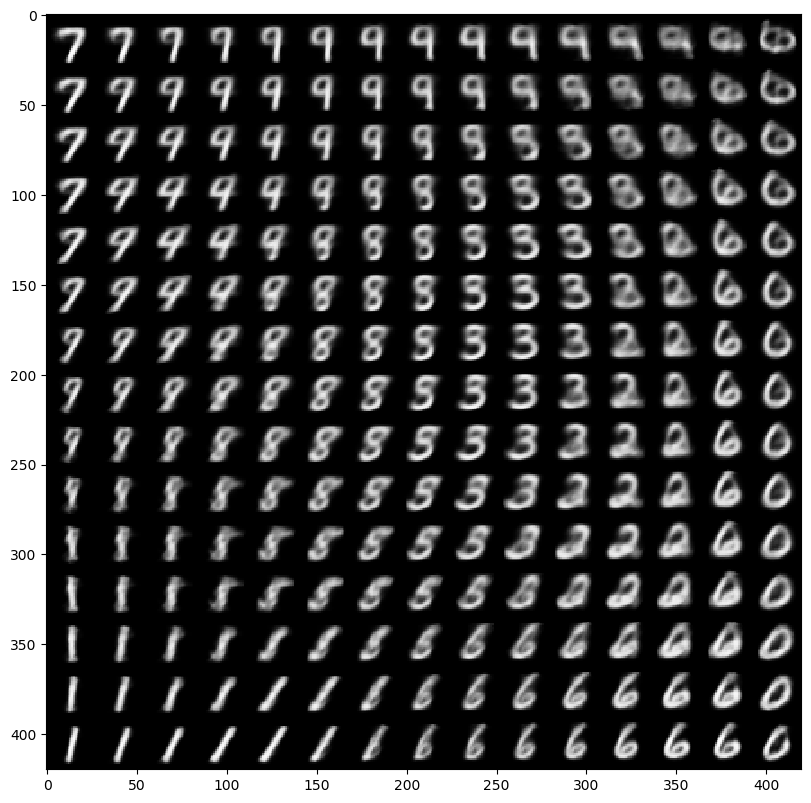

In [15]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(figure, cmap='Greys_r')
plt.show()